In [1]:
from math import ceil
from spatial_scan import scan, deploy, rand_deploy
from vae2d import VAE, encoder, decoder, tf, keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

2023-05-26 18:40:18.034533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 18:40:21.012885: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-26 18:40:21.013114: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-26 18:40:21.013144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
nepochs = 1000

In [3]:
batch_len = 1000
lmax=0.5
half=False

with open("../overfittabile_x.txt") as f:
    data = [[float(i.strip()) for i in s.split(" ") if i!=""] for s in f.read().split("\n") if s!=""]
    xyz=[[[data[h][i+2*j]for i in range(2)]for j in range(len(data[h])//2)]for h in range(len(data))]
    #print(len(data[0]), len(xyz[0]), len(xyz[0][0]))
    del data

# print(len(data), [len(data[i]) for i in range(len(data))])
model_checkpoint_callback = keras.callbacks.ModelCheckpoint("./checkpoints2d/", save_best_only=True)
# currently unused
    

In [4]:
if True:#len(argv)>2 and argv[2]=="--resume":
    encoder=keras.models.load_model("./overfittable-model-info2d/enc")
    decoder=keras.models.load_model("./overfittable-model-info2d/dec")

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())


def change_l(e,log):
    global lmax, half
    vae.l = (1-1/(1+e/10))*lmax
    lmax+=0.0005
    if not half:
        vae.r = 1/(1+e/10)
    else:
        vae.r = 0
    #print("l: ", vae.l)

regularization_callback = keras.callbacks.LambdaCallback(on_epoch_begin=change_l)

losses=[]
rec_losses=[]
kl_losses=[]
l_values=[]

In [ ]:
for i in range(ceil(len(xyz)/batch_len)):
    bdata = [] # will hold bucketed data version
    for j in range(batch_len*i, batch_len*(i+1)):
        if j>len(xyz):
            break
        #print(xyz[j])
        bdata.append([scan(xyz[j],8,8, dim=2)])
    dataset = tf.data.Dataset.from_tensor_slices((bdata,))
    print(" ----- i: ",i)
    if i>ceil(len(xyz)/batch_len)//2:
        half=True
    
    vae.fit(dataset, epochs=nepochs, batch_size=128, callbacks=[regularization_callback], verbose=0)
    losses.extend(vae.history.history["loss"])
    rec_losses.extend(vae.history.history["reconstruction_loss"])
    kl_losses.extend(vae.history.history["kl_loss"])
    l_values.extend([(1-1/(1+i))*lmax for i in range(nepochs)])

try:
    vae.load_weights("./checkpoints2d/")
except Exception as e:
    print(e)
finally:
    keras.models.save_model(vae.encoder, "./overfittable-model-info2d/enc/")
    keras.models.save_model(vae.decoder, "./overfittable-model-info2d/dec/")
    

vae.history.history

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
fig, ax = plt.subplots(ncols=4)
ax[0].plot(losses[2700:])#vae.history.history["loss"])
ax[1].plot(rec_losses[2700:])#vae.history.history["reconstruction_loss"])
ax[2].plot(kl_losses[2700:])#vae.history.history["kl_loss"])
ax[3].plot(l_values[2700:])
fig.tight_layout()

In [ ]:
test_set=[]
for j in range(batch_len, batch_len*2):
    if j>len(xyz):
        break
    test_set.append([scan(xyz[j],8,8, dim=2)])

dataset = tf.data.Dataset.from_tensor_slices((test_set,))

pred = vae.encoder.predict(dataset)

In [ ]:
fig,ax=plt.subplots(ncols=5, nrows=5)
for i in range(5):
    for j in range(5):
        if i!=j:
            ax[i][j].scatter(x=[p[i] for p in pred[2]], y=[p[j] for p in pred[2]], s=5)
        else:
            ax[i][i].hist(x=[p[i] for p in pred[2]])
fig.tight_layout()
#print(len([p[0] for p in pred[2]]), len([p[1] for p in pred[2]]))

In [5]:
ndata=2000
N=25
rdata=np.random.normal(0,2, size=(ndata,5))
rec=decoder.predict(rdata)
x=[None for i in range(ndata)]
y=[None for i in range(ndata)]
for i in range(ndata):
    #print(i)
    x[i],y[i]=rand_deploy(rec[i], dim=2, N=N)

63/63 [==============================] - 3s 38ms/step


In [6]:
#print([(len(x[i]),len(y[i])) for i in range(ndata)])

In [7]:
rec.std()

0.022108007

<IPython.core.display.Javascript object>


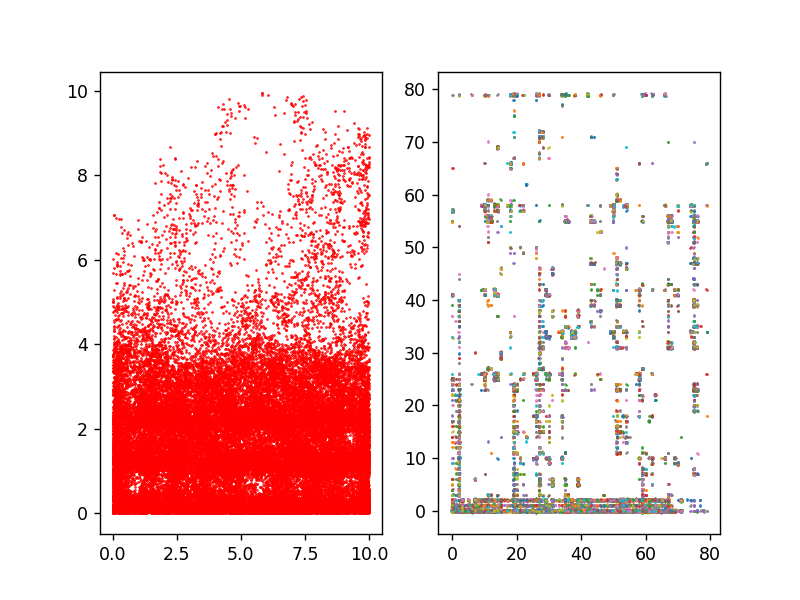

In [8]:
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
fig, ax=plt.subplots(ncols=2)

In [15]:
for i in range(ndata):
    ax[1].scatter(np.random.normal(0,0.1, size=(N,))+y[i],np.random.normal(0,0.1, size=(N,))+x[i], marker=".", s=1)

In [10]:
"""xplot=[]
yplot=[]
cols=[]
for i in range(len(rec[0])): #80
    xplot.append([])
    yplot.append([])
    cols.append([])
    for j in range(len(rec[0][i])): #80
        xplot[i].append(j/8)
        yplot[i].append(i/8)
        cols[i].append(0)
        for k in range(len(rec)):
            cols[i][j] += rec[k][i][j]
        #cols[i][j] *= 30

xplot=np.array(xplot).flatten()
yplot=np.array(yplot).flatten()
cols=np.array(cols).flatten()
rgb = mpl.colormaps["coolwarm"](cols)

ax[1].scatter(yplot, xplot, s=1, c=rgb)
"""
for j in range(len(xyz)):
    ax[0].scatter([i[0] for i in xyz[j]],[i[1] for i in xyz[j]] , color="red", marker=".", s=1)